# Housing Affordability Analysis

This notebook analyzes housing affordability across Victorian suburbs by calculating the ratio of median rent to median household income using 2021 census data.


The analysis helps identify areas where housing costs are most burdensome relative to local incomes, providing insights for policy and investment decisions.


# Housing Affordability 
- Ratio of median household income to median rent
- Using 2021 census data

In [1]:
import pandas as pd


In [2]:
def merge_on_suburb(column, data, destination):
    """ 
    A function to merge on suburb when they are of different forms
    Takes the average of combo suburbs - so only works for numeric data
    """
    # incoming dataset needs to have brackets/ extra info removed
    # also ensure lower case
    data["suburb"] = data["suburb"].str.replace(r"\s*\([^)]*\)", "", regex=True)
    data["suburb"] = data['suburb'].str.lower()

    # extra adjustments needed to match specific formatting
    data["suburb"] = data["suburb"].replace("brunswick west", "west brunswick")
    data["suburb"] = data["suburb"].replace("brunswick east", "east brunswick")
    data["suburb"] = data["suburb"].replace("st kilda east", "east st kilda")
    data["suburb"] = data["suburb"].replace("st kilda west", "west st kilda")
    data["suburb"] = data["suburb"].replace("hawthorn east", "east hawthorn")
    data["suburb"] = data["suburb"].replace("east bendigo", "bendigo east")

    data["suburb"] = data["suburb"].replace("mount martha", "mt martha")
    data["suburb"] = data["suburb"].replace("mount eliza", "mt eliza")

    data["suburb"] = data["suburb"].replace("wangaratta", "wanagaratta")
    data["suburb"] = data["suburb"].replace("newcomb", "newcombe")
    
    
    # First create conjoined suburbs
    # iterate through the suburbs 
    for suburb in destination["suburb"].unique():
        # check if we have a hyphen suburb needs to be averaged
        if "-" in suburb:
            to_avg = suburb.split("-")
            # take average of metric from each suburb
            if set(to_avg).issubset(set(data['suburb'])) == True:
                # we can  take an average
                # Filter to only those suburbs
                subset = data[data['suburb'].isin(to_avg)]
                
                # Compute the average population
                average_population = subset[column].mean()
                
                new_row = pd.DataFrame({
                    'suburb': [suburb], 
                    column: [average_population]
                })
                
                # Append to the other DataFrame
                data = pd.concat([data, new_row], ignore_index=True)
                                
    # now do a merge on suburb
    merged = pd.merge( destination, data, on='suburb', how='inner') 

    return merged
        

In [4]:
data_path = "../data/curated/rent_growth/panel_data.csv"
panel_data_1 = pd.read_csv(data_path)


# Use median stats to add median personal income
data_path = "../data/processed/census/median_stats.csv"
census_medians = pd.read_csv(data_path)
# Extract Median Household Income
subset = census_medians[census_medians["Statistic"] == "Median total household income ($/weekly)"]
subset = subset.rename(columns={"Value": 
                                "median_household_income"}).drop(columns=["Statistic"])
subset = subset.rename(columns={"Suburb": "suburb"})
panel_data_2 = merge_on_suburb("median_household_income", subset, panel_data_1)


# Extract Median Rent
subset_age = census_medians[census_medians["Statistic"] == "Median rent ($/weekly)(a)"]
subset_age = subset_age.rename(columns={"Value": 
                                "median_rent_census"}).drop(columns=["Statistic"])
subset_age = subset_age.rename(columns={"Suburb": "suburb"})
panel_data_3 = merge_on_suburb("median_rent_census", subset_age, panel_data_2)
print(panel_data_3)

                                       suburb    property_type  quarter  year  \
0       albert park-middle park-west st kilda   1 bedroom flat        1  2000   
1                                    armadale   1 bedroom flat        1  2000   
2                               carlton north   1 bedroom flat        1  2000   
3                           carlton-parkville   1 bedroom flat        1  2000   
4                      collingwood-abbotsford   1 bedroom flat        1  2000   
...                                       ...              ...      ...   ...   
101437                              traralgon  4 bedroom house        1  2025   
101438                            wanagaratta  4 bedroom house        1  2025   
101439                               warragul  4 bedroom house        1  2025   
101440                            warrnambool  4 bedroom house        1  2025   
101441                                wodonga  4 bedroom house        1  2025   

        median_rent quarter

In [5]:
# Merge with panel data for correct number of suburbs

affordability = panel_data_3[['suburb', 'median_rent_census','median_household_income']]
affordability = affordability.drop_duplicates(subset='suburb').reset_index(drop=True)
affordability['income_rent_ratio'] = affordability['median_rent_census'] / affordability['median_household_income']
print(affordability)
affordability.to_csv('../data/analysis/affordabilit.csv', index=False)

                                    suburb  median_rent_census  \
0    albert park-middle park-west st kilda          525.666667   
1                                 armadale          421.000000   
2                            carlton north          552.000000   
3                        carlton-parkville          380.500000   
4                   collingwood-abbotsford          425.000000   
..                                     ...                 ...   
138                            castlemaine          300.000000   
139                                seymour          250.000000   
140                                 keilor          400.000000   
141                               rowville          441.000000   
142                              docklands          411.000000   

     median_household_income  income_rent_ratio  
0                2450.666667           0.214499  
1                2193.000000           0.191974  
2                2400.000000           0.230000  
3      

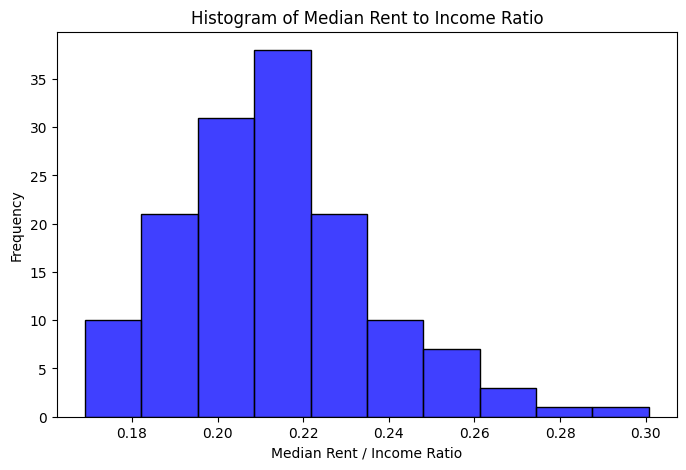

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
sns.histplot(affordability['income_rent_ratio'], bins=10, color='blue')
plt.title('Histogram of Median Rent to Income Ratio')
plt.xlabel('Median Rent / Income Ratio')
plt.ylabel('Frequency')
plt.show()

In [7]:
top_6 = affordability.nlargest(6, 'income_rent_ratio')
print(top_6)

                         suburb  median_rent_census  median_household_income  \
22                     box hill               381.0                   1267.0   
129                      melton               300.0                   1058.0   
133            thomastown-lalor               350.5                   1286.5   
138                 castlemaine               300.0                   1106.0   
27                      clayton               400.0                   1494.0   
58   broadmeadows-roxburgh park               360.5                   1390.0   

     income_rent_ratio  
22            0.300710  
129           0.283554  
133           0.272445  
138           0.271248  
27            0.267738  
58            0.259353  


In [8]:
bottom_6 =  affordability.nsmallest(6, 'income_rent_ratio')
print(bottom_6)

                          suburb  median_rent_census  median_household_income  \
120                    swan hill          235.000000              1390.000000   
73          ivanhoe-ivanhoe east          440.500000              2604.500000   
99                       newtown          360.000000              2092.000000   
44                       malvern          450.000000              2606.000000   
70   eltham-research-montmorency          430.333333              2447.666667   
55                west footscray          351.000000              1989.000000   

     income_rent_ratio  
120           0.169065  
73            0.169130  
99            0.172084  
44            0.172678  
70            0.175814  
55            0.176471  
